In [45]:
from emle.models import EMLE
from emle_bespoke._constants import HARTREE_TO_KJ_MOL
import pickle as pkl

In [46]:
with open(
    "/home/joaomorado/mnsol_sampling/second_half/methylpentanoate_ref_data.pkl", "rb"
) as f:
    data = pkl.load(f)

data.keys()

dict_keys(['z', 'xyz_qm', 's', 'mu', 'q_core', 'q_val', 'alpha', 'xyz_mm', 'charges_mm', 'e_static', 'e_ind'])

In [47]:
device = data["z"][0].device
dtype = data["xyz_mm"][0].dtype

print("Device:", device)
print("Data type:", dtype)

emle_model = EMLE(device=device, dtype=dtype)

Device: cuda:0
Data type: torch.float64
/home/joaomorado/opt/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/torchani/resources/


In [48]:
# calc = EMLECalculator(device="cuda", backend=None)

e_static_emle = []
e_ind_emle = []
for i in range(len(data["z"])):
    # en = calc._sire_callback(data["z"][i].cpu(), data["charges_mm"][i].cpu(), data["xyz_qm"][i].cpu(), data["xyz_mm"][i].cpu())
    e_static, e_ind = emle_model.forward(
        data["z"][i], data["charges_mm"][i], data["xyz_qm"][i], data["xyz_mm"][i]
    )
    e_static_emle.append(e_static * HARTREE_TO_KJ_MOL)
    e_ind_emle.append(e_ind * HARTREE_TO_KJ_MOL)
    # print(en[0] - (e_static_emle[-1].item() + e_ind_emle[-1].item()))

<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:85: SyntaxWarning: invalid escape sequence '\m'
<>:86: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:85: SyntaxWarning: invalid escape sequence '\m'
<>:86: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1134652/4277316783.py:43: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_xlabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_1134652/4277316783.py:44: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_ylabel("$E_{\mathrm{QM}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_1134652/4277316783.py:63: SyntaxWarning: invalid escape sequence '\m'
  axes[1].set_x

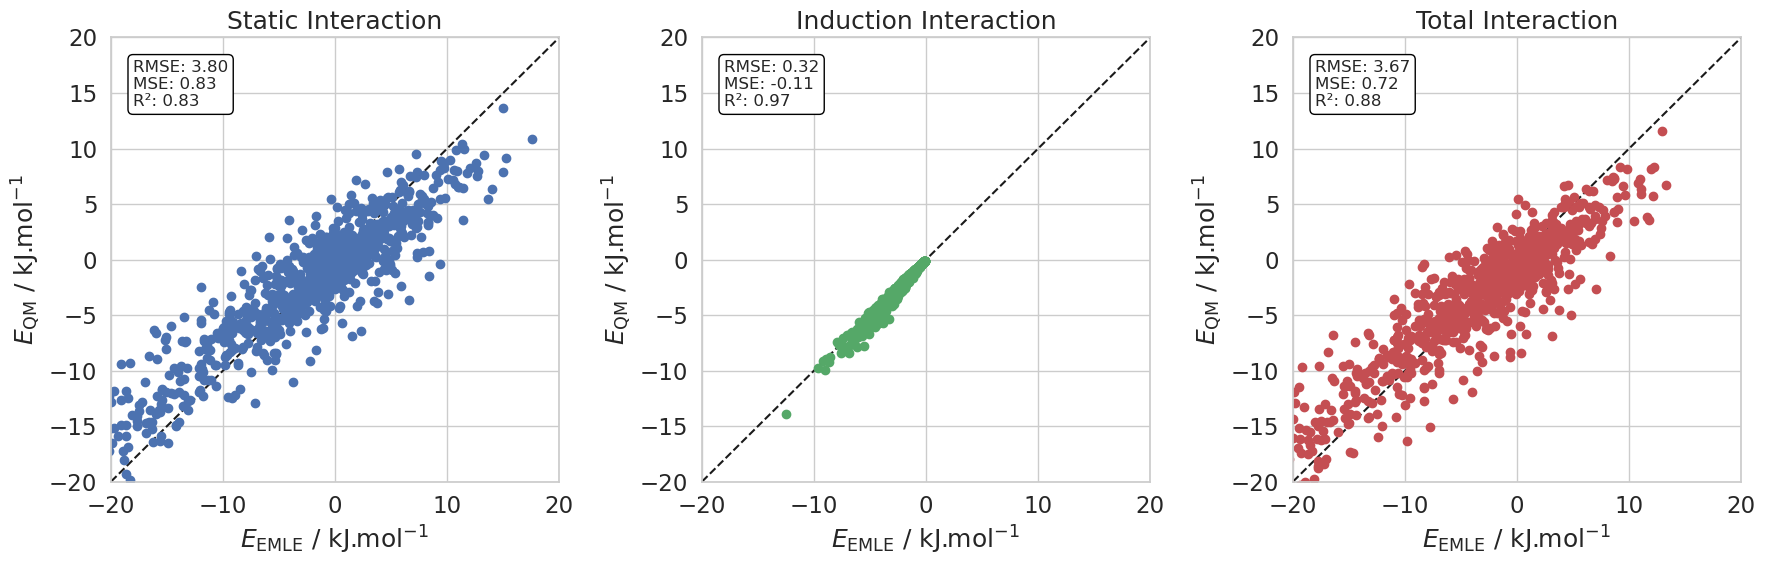

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid", font_scale=1.5)

# Example data (replace with your actual data)
e_static = np.array([x.item() for x in data["e_static"]])
e_ind = np.array([x.item() for x in data["e_ind"]])
e_static_emle = np.array([x.item() for x in e_static_emle])
e_ind_emle = np.array([x.item() for x in e_ind_emle])

# Create the figure and axes for 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the x values for the plot (reference line)
x = np.linspace(-1000, 1000, 100)
y = x


# Function to compute RMSE, MSE, and R^2
def compute_metrics(true_values, predicted_values):
    mse = np.mean(true_values - predicted_values)
    rmse = sqrt(np.mean((true_values - predicted_values) ** 2))
    r2 = r2_score(true_values, predicted_values)
    return rmse, mse, r2


# Set limits for all subplots and plot reference line
xmin, xmax = -20, 20
ymin, ymax = -20, 20
for ax in axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.plot(x, y, "k--", label="Reference Line")

# Static subplot
rmse_static, mse_static, r2_static = compute_metrics(e_static, e_static_emle)
axes[0].plot(e_static_emle, e_static, "bo", label="Static")
axes[0].set_xlabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[0].set_ylabel("$E_{\mathrm{QM}}$ / kJ.mol$^{-1}$")
axes[0].set_title("Static Interaction")
# axes[0].legend()

# Display RMSE, MSE, R^2 on the Static plot
axes[0].text(
    0.05,
    0.95,
    f"RMSE: {rmse_static:.2f}\nMSE: {mse_static:.2f}\nR²: {r2_static:.2f}",
    transform=axes[0].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Induction subplot
rmse_ind, mse_ind, r2_ind = compute_metrics(e_ind, e_ind_emle)
axes[1].plot(e_ind_emle, e_ind, "go", label="Induction")
axes[1].set_xlabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[1].set_ylabel("$E_{\mathrm{QM}}$ / kJ.mol$^{-1}$")
axes[1].set_title("Induction Interaction")
# axes[1].legend()

# Display RMSE, MSE, R^2 on the Induction plot
axes[1].text(
    0.05,
    0.95,
    f"RMSE: {rmse_ind:.2f}\nMSE: {mse_ind:.2f}\nR²: {r2_ind:.2f}",
    transform=axes[1].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Total subplot
rmse_total, mse_total, r2_total = compute_metrics(
    e_static + e_ind, e_static_emle + e_ind_emle
)
axes[2].plot(e_static_emle + e_ind_emle, e_static + e_ind, "ro", label="Total")
axes[2].set_xlabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[2].set_ylabel("$E_{\mathrm{QM}}$ / kJ.mol$^{-1}$")
axes[2].set_title("Total Interaction")
# axes[2].legend()

# Display RMSE, MSE, R^2 on the Total plot
axes[2].text(
    0.05,
    0.95,
    f"RMSE: {rmse_total:.2f}\nMSE: {mse_total:.2f}\nR²: {r2_total:.2f}",
    transform=axes[2].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Adjust the layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [50]:
with open(
    "/home/joaomorado/repos/emle-bespoke/examples/notebooks/emle_sampling/n-pentane_e_ind_emle.pkl",
    "rb",
) as f:
    e_ind_emle_old = pkl.load(f)

with open(
    "/home/joaomorado/repos/emle-bespoke/examples/notebooks/emle_sampling/n-pentane_e_static_emle.pkl",
    "rb",
) as f:
    e_static_emle_old = pkl.load(f)

with open(
    "/home/joaomorado/repos/emle-bespoke/examples/notebooks/emle_sampling/n-pentane_e_ind_ref.pkl",
    "rb",
) as f:
    e_ind_ref_old = pkl.load(f)

with open(
    "/home/joaomorado/repos/emle-bespoke/examples/notebooks/emle_sampling/n-pentane_e_static_ref.pkl",
    "rb",
) as f:
    e_static_ref_old = pkl.load(f)

e_ind_ref_old = np.asarray(e_ind_ref_old)
e_static_ref_old = np.asarray(e_static_ref_old)
e_ind_emle_old = np.asarray(e_ind_emle_old)
e_static_emle_old = np.asarray(e_static_emle_old)

<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:65: SyntaxWarning: invalid escape sequence '\m'
<>:66: SyntaxWarning: invalid escape sequence '\m'
<>:92: SyntaxWarning: invalid escape sequence '\m'
<>:93: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:65: SyntaxWarning: invalid escape sequence '\m'
<>:66: SyntaxWarning: invalid escape sequence '\m'
<>:92: SyntaxWarning: invalid escape sequence '\m'
<>:93: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1134652/867409797.py:45: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_xlabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_1134652/867409797.py:46: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_ylabel("$E_{\mathrm{QM}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_1134652/867409797.py:65: SyntaxWarning: invalid escape sequence '\m'
  axes[1].set_xlab

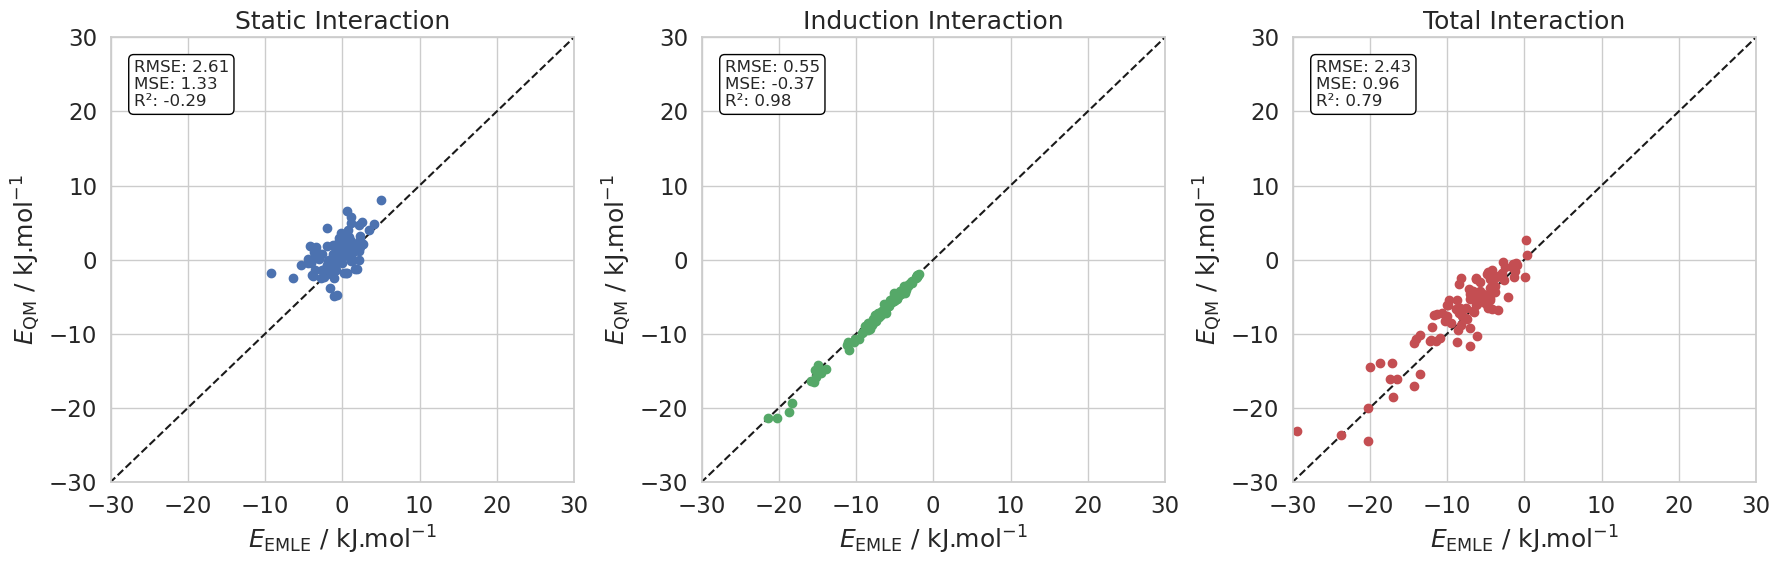

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid", font_scale=1.5)

# Example data (replace with your actual data)
e_static = np.array([x.item() for x in data["e_static"]])
e_ind = np.array([x.item() for x in data["e_ind"]])
e_static_emle = np.array([x.item() for x in e_static_emle])
e_ind_emle = np.array([x.item() for x in e_ind_emle])

# Create the figure and axes for 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the x values for the plot (reference line)
x = np.linspace(-1000, 1000, 100)
y = x


# Function to compute RMSE, MSE, and R^2
def compute_metrics(true_values, predicted_values):
    mse = np.mean(true_values - predicted_values)
    rmse = sqrt(np.mean((true_values - predicted_values) ** 2))
    r2 = r2_score(true_values, predicted_values)
    return rmse, mse, r2


# Set limits for all subplots and plot reference line
xmin, xmax = -30, 30
ymin, ymax = -30, 30
for ax in axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.plot(x, y, "k--", label="Reference Line")

# Static subplot
rmse_static, mse_static, r2_static = compute_metrics(
    e_static_ref_old, e_static_emle_old
)
axes[0].plot(e_static_emle_old, e_static_ref_old, "bo", label="Static")
axes[0].set_xlabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[0].set_ylabel("$E_{\mathrm{QM}}$ / kJ.mol$^{-1}$")
axes[0].set_title("Static Interaction")
# axes[0].legend()

# Display RMSE, MSE, R^2 on the Static plot
axes[0].text(
    0.05,
    0.95,
    f"RMSE: {rmse_static:.2f}\nMSE: {mse_static:.2f}\nR²: {r2_static:.2f}",
    transform=axes[0].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Induction subplot
rmse_ind, mse_ind, r2_ind = compute_metrics(e_ind_ref_old, e_ind_emle_old)
axes[1].plot(e_ind_emle_old, e_ind_ref_old, "go", label="Induction")
axes[1].set_xlabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[1].set_ylabel("$E_{\mathrm{QM}}$ / kJ.mol$^{-1}$")
axes[1].set_title("Induction Interaction")
# axes[1].legend()

# Display RMSE, MSE, R^2 on the Induction plot
axes[1].text(
    0.05,
    0.95,
    f"RMSE: {rmse_ind:.2f}\nMSE: {mse_ind:.2f}\nR²: {r2_ind:.2f}",
    transform=axes[1].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Total subplot
rmse_total, mse_total, r2_total = compute_metrics(
    e_static_ref_old + e_ind_ref_old, e_static_emle_old + e_ind_emle_old
)
axes[2].plot(
    e_static_emle_old + e_ind_emle_old,
    e_static_ref_old + e_ind_ref_old,
    "ro",
    label="Total",
)
axes[2].set_xlabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[2].set_ylabel("$E_{\mathrm{QM}}$ / kJ.mol$^{-1}$")
axes[2].set_title("Total Interaction")
# axes[2].legend()

# Display RMSE, MSE, R^2 on the Total plot
axes[2].text(
    0.05,
    0.95,
    f"RMSE: {rmse_total:.2f}\nMSE: {mse_total:.2f}\nR²: {r2_total:.2f}",
    transform=axes[2].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Adjust the layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()